# Benchmark final

In [1]:
import os
import sys
from pathlib import Path


CWD = Path.cwd()
PROJECT_ROOT = CWD.parent.parent
DB_PATH = (PROJECT_ROOT / "mlflow.db").resolve()
ARTIFACT_ROOT = (PROJECT_ROOT / "artifacts").resolve()
ARTIFACT_ROOT.mkdir(parents=True, exist_ok=True)

FEATURE_REDUCTION_DIR = PROJECT_ROOT / "reports" / "feature_reduction"
FEATURE_REDUCTION_DIR.mkdir(parents=True, exist_ok=True)

os.environ["MLFLOW_TRACKING_URI"] = f"sqlite:///{DB_PATH.as_posix()}"
os.environ["MLFLOW_ARTIFACT_URI"] = ARTIFACT_ROOT.as_uri()


sys.path.append(str(PROJECT_ROOT))

import mlflow  


mlflow.set_tracking_uri(os.environ["MLFLOW_TRACKING_URI"])

print("CWD =", CWD)
print("Tracking URI =", mlflow.get_tracking_uri())
print("Artifacts root (env) =", os.environ["MLFLOW_ARTIFACT_URI"])

CWD = c:\Users\yoann\Documents\open classrooms\projet 8\livrables\pret a dépenser\notebooks\03_modeling
Tracking URI = sqlite:///C:/Users/yoann/Documents/open classrooms/projet 8/livrables/pret a dépenser/mlflow.db
Artifacts root (env) = file:///C:/Users/yoann/Documents/open%20classrooms/projet%208/livrables/pret%20a%20d%C3%A9penser/artifacts


In [2]:
import pandas as pd
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import numpy as np
from src.modeling.train import train_with_cv
from src.modeling.prepare_for_model import prepare_application_for_model
from src.tracking import mlflow_tracking
import  json
from datetime import datetime
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    recall_score,
    precision_score,
    f1_score,
    fbeta_score,
)
import matplotlib.pyplot as plt

EXPERIMENT_NAME = "home_credit_final_benchmark"
exp_id = mlflow_tracking.get_or_create_experiment(EXPERIMENT_NAME, ARTIFACT_ROOT)
mlflow.set_experiment(EXPERIMENT_NAME)
#mlflow ui --backend-store-uri sqlite:///mlflow.db

c:\Users\yoann\Documents\open classrooms\projet 8\livrables\pret a dépenser\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026/02/18 10:28:52 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/02/18 10:28:52 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags T

<Experiment: artifact_location='file:///C:/Users/yoann/Documents/open%20classrooms/projet%208/livrables/pret%20a%20d%C3%A9penser/artifacts', creation_time=1771406933101, experiment_id='1', last_update_time=1771406933101, lifecycle_stage='active', name='home_credit_final_benchmark', tags={}>

## Chargement des données + feature set top125

In [3]:
DATA_DIR = PROJECT_ROOT / "data" / "processed"
TRAIN_PATH = DATA_DIR / "train_split.csv"
VALID_PATH = DATA_DIR / "valid_split.csv"
TEST_PATH  = DATA_DIR / "test_split.csv"

df_train = pd.read_csv(TRAIN_PATH)
df_valid = pd.read_csv(VALID_PATH)
df_test  = pd.read_csv(TEST_PATH)

# préparation générique
X_train_full, y_train = prepare_application_for_model(df_train, model_type="boosting")
X_valid_full, y_valid = prepare_application_for_model(df_valid, model_type="boosting")
X_test_full,  y_test  = prepare_application_for_model(df_test,  model_type="boosting")

FEATURE_REDUCTION_DIR = PROJECT_ROOT / "reports" / "feature_reduction"
FEATURE_SET_NAME = "top125_nocorr"
kept_file = FEATURE_REDUCTION_DIR / f"kept_features_{FEATURE_SET_NAME}.txt"

kept_features = [
    l.strip() for l in kept_file.read_text(encoding="utf-8").splitlines()
    if l.strip()
]
kept_features = [c for c in kept_features if c in X_train_full.columns]

X_train = X_train_full[kept_features].copy()
X_valid = X_valid_full[kept_features].copy()
X_test  = X_test_full[kept_features].copy()

print("TRAIN:", X_train.shape)
print("VALID:", X_valid.shape)
print("TEST :", X_test.shape)

TRAIN: (215257, 125)
VALID: (46127, 125)
TEST : (46127, 125)


## Chargement hyperparams Optuna + seuils (noms réels)

In [4]:
REPORTS_DIR_THR = PROJECT_ROOT / "reports" / "threshold_optimization"
REPORTS_DIR_HP  = PROJECT_ROOT / "reports" / "hyperparameter_optimization"

thr_lgb = float(json.loads((REPORTS_DIR_THR / "best_threshold_lightgbm_top125_nocorr.json").read_text())["threshold"])
thr_xgb = float(json.loads((REPORTS_DIR_THR / "best_threshold_xgboost_top125_nocorr.json").read_text())["threshold"])
thr_cb  = float(json.loads((REPORTS_DIR_THR / "best_threshold_catboost_top125_nocorr.json").read_text())["threshold"])

params_lgb = json.loads((REPORTS_DIR_HP / "optuna_best_lightgbm_top125_nocorr.json").read_text())["best_params"]
params_xgb = json.loads((REPORTS_DIR_HP / "optuna_best_xgboost_top125_nocorr.json").read_text())["best_params"]
params_cb  = json.loads((REPORTS_DIR_HP / "optuna_best_catboost_top125_nocorr.json").read_text())["best_params"]

print("Thresholds:", thr_lgb, thr_xgb, thr_cb)

Thresholds: 0.52 0.46 0.5


In [5]:

RANDOM_STATE = 42

final_params_lgb = {
    "objective": "binary",
    "class_weight": "balanced",
    "random_state": RANDOM_STATE,
    "n_jobs": -1,
    "verbosity": -1,
    **params_lgb,
}

final_params_xgb = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "tree_method": "hist",
    "random_state": RANDOM_STATE,
    "n_jobs": -1,
    **params_xgb,
}

final_params_cb = {
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "auto_class_weights": "Balanced",
    "random_seed": RANDOM_STATE,
    "verbose": False,
    **params_cb,
}

## Fonctions: métriques + préparation matrices (LGB / XGB / CB)

In [6]:
REG_LGB = "home_credit_lgbm"
REG_XGB = "home_credit_xgb"
REG_CB  = "home_credit_catboost"

COST_FN = 10
COST_FP = 1
FBETA_BETA = 3
RANDOM_STATE = 42

from src.modeling.metrics import compute_metrics_and_cost


X_tv_raw = pd.concat([X_train, X_valid], axis=0)
y_tv = pd.concat([y_train, y_valid], axis=0)

results = []
fitted = {}   

## Entraînement final: TRAIN+VALID -> TEST + logging MLflow

In [7]:
import numpy as np
import pandas as pd


from src.modeling.prepare_lgb import prepare_lgb_matrix

from src.modeling.prepare_xgboost import prepare_xgb
from src.modeling.prepare_catboost import prepare_catboost_with_feature

In [8]:
# Light bgm
X_tv_lgb, lgb_cat_cols = prepare_lgb_matrix(X_tv_raw)
X_test_lgb, _ = prepare_lgb_matrix(X_test)

model_lgb = LGBMClassifier(**final_params_lgb)

t0 = datetime.now()
model_lgb.fit(
    X_tv_lgb, y_tv,
    categorical_feature=lgb_cat_cols if len(lgb_cat_cols) > 0 else "auto"
)
train_time = (datetime.now() - t0).total_seconds()

proba_lgb = model_lgb.predict_proba(X_test_lgb)[:, 1]
res_lgb = res_lgb = compute_metrics_and_cost(
    y_true=y_test,
    proba=proba_lgb,
    threshold=thr_lgb,
    cost_fn=COST_FN,
    cost_fp=COST_FP,
    beta=FBETA_BETA,
)
res_lgb.update({"model": "LightGBM", "train_time_sec": float(train_time)})

results.append(res_lgb)
fitted["LightGBM"] = {"model": model_lgb, "proba_test": proba_lgb, "X_tv": X_tv_lgb, "X_test": X_test_lgb, "threshold": thr_lgb}

In [9]:


X_tv_xgb = prepare_xgb(X_tv_raw)
X_test_xgb = prepare_xgb(X_test)

model_xgb = XGBClassifier(**final_params_xgb)

t0 = datetime.now()
model_xgb.fit(X_tv_xgb, y_tv)
train_time = (datetime.now() - t0).total_seconds()

proba_xgb = model_xgb.predict_proba(X_test_xgb)[:, 1]
res_xgb = compute_metrics_and_cost(y_true=y_test, proba=proba_xgb, threshold=thr_xgb, cost_fn=COST_FN, cost_fp=COST_FP, beta=FBETA_BETA)
res_xgb.update({"model": "XGBoost", "train_time_sec": float(train_time)})

results.append(res_xgb)
fitted["XGBoost"] = {"model": model_xgb, "proba_test": proba_xgb, "X_tv": X_tv_xgb, "X_test": X_test_xgb, "threshold": thr_xgb}

In [10]:
X_tv_cb, cat_idx_tv = prepare_catboost_with_feature(X_tv_raw)
X_test_cb, cat_idx_test = prepare_catboost_with_feature(X_test)

model_cb = CatBoostClassifier(**final_params_cb)

t0 = datetime.now()
model_cb.fit(X_tv_cb, y_tv, cat_features=cat_idx_tv if len(cat_idx_tv) > 0 else None)
train_time = (datetime.now() - t0).total_seconds()

proba_cb = model_cb.predict_proba(X_test_cb)[:, 1]
res_cb = compute_metrics_and_cost(y_true=y_test, proba=proba_cb, threshold=thr_cb, cost_fn=COST_FN, cost_fp=COST_FP, beta=FBETA_BETA)
res_cb.update({"model": "CatBoost", "train_time_sec": float(train_time)})

results.append(res_cb)
fitted["CatBoost"] = {"model": model_cb, "proba_test": proba_cb, "X_tv": X_tv_cb, "X_test": X_test_cb, "threshold": thr_cb, "cat_idx": cat_idx_tv}

In [11]:
df_final = (
    pd.DataFrame(results)
      .sort_values(by=["business_cost", "recall", f"fbeta_{FBETA_BETA}", "auc"],
                   ascending=[True, False, False, False])
      .reset_index(drop=True)
)
df_final

,auc,recall,precision,f1,fbeta_3,business_cost,tn,fp,fn,tp,model,train_time_sec
0,0.788531,0.707035,0.188031,0.297061,0.554094,22280.0,31033,11370,1091,2633,CatBoost,115.176904
1,0.784136,0.669710,0.193498,0.300247,0.537442,22695.0,32008,10395,1230,2494,LightGBM,8.090557
2,0.787716,0.741407,0.173517,0.281218,0.558590,22781.0,29252,13151,963,2761,XGBoost,20.141979


In [12]:
from src.tracking.tracking_final_log import log_and_register_baseline
COST_FN = 10
COST_FP = 1
FBETA_BETA = 3
# 3 baselines
log_and_register_baseline("LightGBM", REG_LGB, fitted["LightGBM"]["model"], final_params_lgb, res_lgb, thr_lgb, FEATURE_SET_NAME, kept_file,COST_FN=COST_FN,COST_FP=COST_FP,FBETA_BETA=FBETA_BETA)
log_and_register_baseline("XGBoost",   REG_XGB, fitted["XGBoost"]["model"],   final_params_xgb, res_xgb, thr_xgb, FEATURE_SET_NAME, kept_file,COST_FN=COST_FN,COST_FP=COST_FP,FBETA_BETA=FBETA_BETA)
log_and_register_baseline("CatBoost",  REG_CB,  fitted["CatBoost"]["model"],  final_params_cb,  res_cb,  thr_cb,  FEATURE_SET_NAME, kept_file,COST_FN=COST_FN,COST_FP=COST_FP,FBETA_BETA=FBETA_BETA)

print("Baselines loggées + registrées (3 modèles).")

2026/02/18 10:32:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'home_credit_lgbm'.
Created version '1' of model 'home_credit_lgbm'.
c:\Users\yoann\Documents\open classrooms\projet 8\livrables\pret a dépenser\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [10:32:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2026/02/18 10:32:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'home_credit_xgb'.

Baselines loggées + registrées (3 modèles).


Successfully registered model 'home_credit_catboost'.
Created version '1' of model 'home_credit_catboost'.


## Conclusion – Benchmark final et sélection du modèle

Nous avons évalué trois modèles de gradient boosting (LightGBM, XGBoost et CatBoost) sur le jeu de test indépendant, en utilisant :

- un périmètre de **125 variables sélectionnées** par importance globale (gain LightGBM),  
- des **hyperparamètres optimisés avec Optuna** par validation croisée,  
- un **seuil métier spécifique** optimisé sur le jeu de validation afin de minimiser le coût métier  
  \(coût = 10 × FN + 1 × FP\).

Chaque modèle a ensuite été ré-entraîné sur l’ensemble **TRAIN + VALID**, puis évalué une seule fois sur le jeu **TEST**, sans aucune ré-optimisation, afin d’obtenir une estimation non biaisée de la performance finale.

---

### Résultats principaux

Les trois modèles obtiennent des performances proches en termes d’AUC (≈ 0.78) et de rappel, confirmant la stabilité du périmètre réduit.

Cependant, le critère principal de sélection étant le **coût métier**, le modèle retenu est :

> **Modèle gagnant : CatBoost**

Ce modèle présente le **coût métier le plus faible sur le jeu de test**, tout en conservant :

- un **rappel élevé** (bonne détection des défauts),  
- une **AUC compétitive**,  
- un bon compromis précision / rappel via le score **F-beta (β = 3)**, priorisant la réduction des faux négatifs.

Le seuil optimal retenu pour CatBoost est :

> **Seuil métier final : 0.50**

---

### Robustesse et traçabilité

L’ensemble du processus a été entièrement tracé avec **MLflow** :

- optimisation des hyperparamètres (Optuna),  
- optimisation des seuils métier sur VALID,  
- entraînement final et évaluation sur TEST,  
- journalisation des paramètres, métriques, seuils et jeux de variables.

Cette démarche garantit :

- l’absence de fuite de données,  
- la reproductibilité complète des résultats,  
- une séparation claire entre sélection de modèle, réglage du seuil et évaluation finale.

---

### Modèle retenu pour le déploiement

Le modèle **CatBoost – top125_nocorr + hyperparamètres Optuna + seuil métier optimisé** est retenu comme modèle final pour la phase de déploiement.

Il offre le meilleur compromis entre :

- **performance métier (minimisation du coût)**,  
- stabilité statistique,  
- simplicité de mise en production.

### Étapes suivantes

Le modèle **CatBoost** étant retenu comme modèle final, les prochaines étapes sont :

- analyser l’interprétabilité globale et locale du modèle à l’aide de **SHAP**, afin d’identifier les variables les plus influentes dans la décision de crédit ;  
- sauvegarder les explications (valeurs SHAP et graphiques) comme artefacts MLflow ;  
- enregistrer le modèle final dans le **MLflow Model Registry** avec le seuil métier associé, afin de préparer son utilisation dans l’API de scoring et le déploiement en production.

Cette dernière étape permettra de disposer d’un modèle traçable, interprétable et directement exploitable en environnement opérationnel.


## Interprétation globale des résultats SHAP (modèle CatBoost)

Les graphiques SHAP permettent d’interpréter le comportement du modèle final CatBoost en identifiant les variables les plus influentes dans la prédiction du risque de défaut, ainsi que le sens de leur impact.

In [13]:
import shap
import matplotlib.pyplot as plt
WINNER_NAME   = "CatBoost"
REGISTRY_NAME = "home_credit_catboost"   

SHAP_DIR = PROJECT_ROOT / "reports" / "shap" / "catboost"
SHAP_DIR.mkdir(parents=True, exist_ok=True)


X_tv_raw = pd.concat([X_train, X_valid], axis=0)
y_tv     = pd.concat([y_train, y_valid], axis=0)

X_tv_cb, cat_idx_tv = prepare_catboost_with_feature(X_tv_raw)
X_test_cb, _        = prepare_catboost_with_feature(X_test)

winner_model = CatBoostClassifier(**final_params_cb)
winner_model.fit(X_tv_cb, y_tv, cat_features=cat_idx_tv)

proba_test = winner_model.predict_proba(X_test_cb)[:, 1]

# métriques test au seuil métier
winner_test_metrics = compute_metrics_and_cost(
    y_test,
    proba_test,
    threshold=thr_cb,
    cost_fn=COST_FN,
    cost_fp=COST_FP,
    beta=FBETA_BETA
)

print("Winner TEST metrics:", winner_test_metrics)

Winner TEST metrics: {'auc': 0.7885308930146072, 'recall': 0.7070354457572503, 'precision': 0.1880311361851032, 'f1': 0.2970609804253399, 'fbeta_3': 0.5540941518129591, 'business_cost': 22280.0, 'tn': 31033, 'fp': 11370, 'fn': 1091, 'tp': 2633}


In [14]:
MAX_SHAP_ROWS = 10000
if len(X_tv_cb) > MAX_SHAP_ROWS:
    X_shap = X_tv_cb.sample(MAX_SHAP_ROWS, random_state=RANDOM_STATE)
else:
    X_shap = X_tv_cb.copy()

explainer = shap.TreeExplainer(winner_model)

shap_values = explainer.shap_values(X_shap)
shap_pos = shap_values[1] if isinstance(shap_values, list) and len(shap_values) == 2 else shap_values

### Importance globale des variables
Le **graphique d’importance globale** (bar plot) montre que les variables les plus déterminantes sont :
- EXT_SOURCE_2, EXT_SOURCE_3, EXT_SOURCE_1
Ces trois scores externes sont de loin les variables les plus *influentes*.
Ils synthétisent l’historique crédit de l’emprunteur et constituent naturellement les meilleurs prédicteurs du risque de défaut.
- DAYS_EMPLOYED
La stabilité professionnelle joue un rôle important : une ancienneté faible ou atypique est associée à un risque accru.
- Variables financières principales :
AMT_ANNUITY, AMT_CREDIT, AMT_GOODS_PRICE
Elles traduisent la charge de remboursement et la taille du crédit, éléments centraux dans l’évaluation du risque.
Variables socio-démographiques et de contexte :
CODE_GENDER, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, ORGANIZATION_TYPE
Leur influence est plus modérée mais cohérente avec la littérature crédit.
Historique bancaire agrégé :
BUREAU_BUREAU_DEBT_RATIO_MAX / MEAN,
PREV_POS_INSTALMENT_FUTURE_MEAN_*,
PREV_RATIO_REFUSED
Ces variables reflètent le comportement passé vis-à-vis des crédits et renforcent la capacité prédictive du modèle.

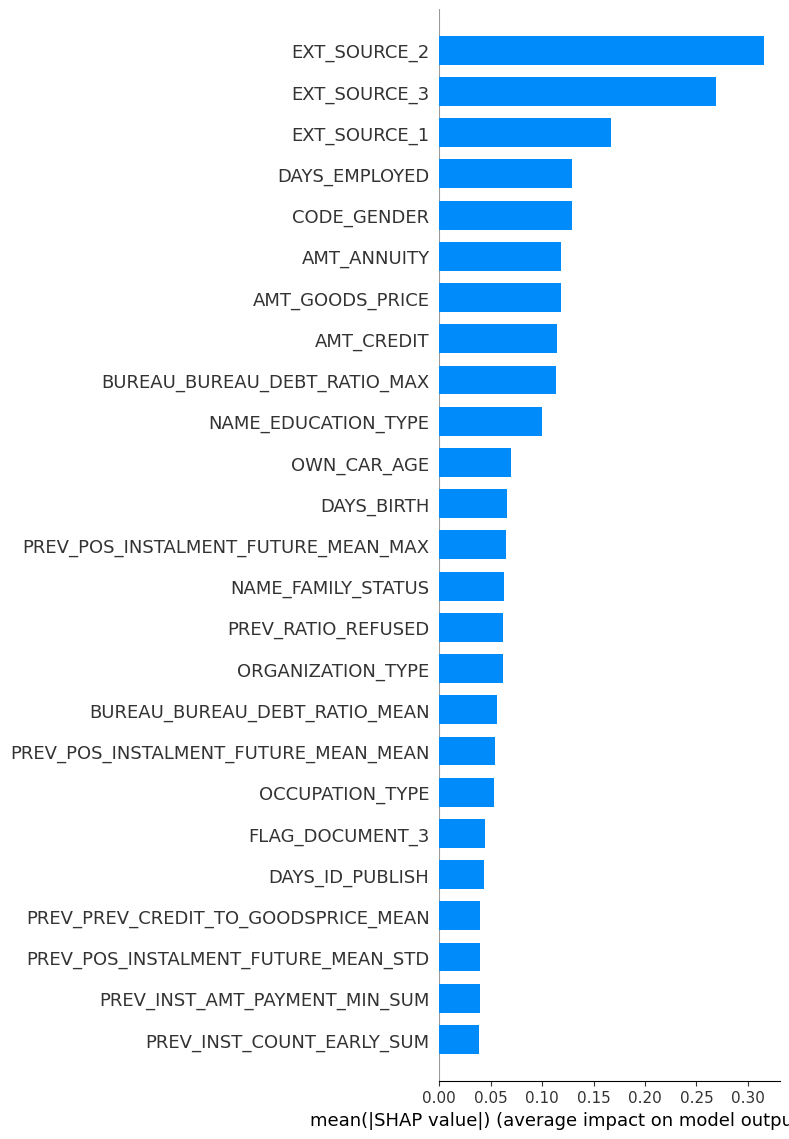

In [15]:
# --- Summary bar
plt.figure()
shap.summary_plot(shap_pos, X_shap, plot_type="bar", max_display=25, show=False)
plt.tight_layout()
bar_file = SHAP_DIR / "shap_summary_bar.png"
plt.savefig(bar_file, dpi=220, bbox_inches="tight")
plt.show()
plt.close()


### Interprétation globale – Beeswarm plot (CatBoost)

Le graphique SHAP de dispersion (beeswarm) présente l’influence conjointe de chaque variable sur la prédiction du risque de défaut.

Chaque point correspond à un client :
- l’axe horizontal représente l’impact SHAP (augmentation ou diminution du risque),
- la couleur indique la valeur de la variable (bleu = faible, rouge = élevée).

Les résultats montrent que :

- **EXT_SOURCE_2, EXT_SOURCE_3 et EXT_SOURCE_1** sont de loin les variables les plus influentes.
  Des valeurs faibles de ces scores externes augmentent fortement le risque de défaut, tandis que des valeurs élevées le réduisent significativement.

- **DAYS_EMPLOYED** joue un rôle important :
  une ancienneté professionnelle faible est associée à un risque plus élevé, alors qu’une ancienneté élevée réduit le risque.

- Les variables financières principales (**AMT_ANNUITY, AMT_CREDIT, AMT_GOODS_PRICE**) ont un effet directionnel cohérent :
  des montants élevés tendent à augmenter la probabilité de défaut.

- Les variables d’historique bancaire agrégé (**PREV_RATIO_REFUSED, BUREAU_BUREAU_DEBT_RATIO_MAX / MEAN, PREV_POS_INSTALMENT_FUTURE_MEAN_***)
  montrent que des comportements passés défavorables (refus, endettement élevé, échéances futures importantes) augmentent le risque prédit.

- Les variables socio-démographiques (**CODE_GENDER, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, ORGANIZATION_TYPE**) ont une influence plus modérée,
  ce qui est cohérent avec un modèle principalement guidé par des critères financiers et comportementaux.

Globalement, le modèle s’appuie principalement sur des variables métier pertinentes
(scores externes, stabilité professionnelle, charge financière et historique crédit),
et les relations apprises sont cohérentes avec les principes classiques du scoring bancaire.

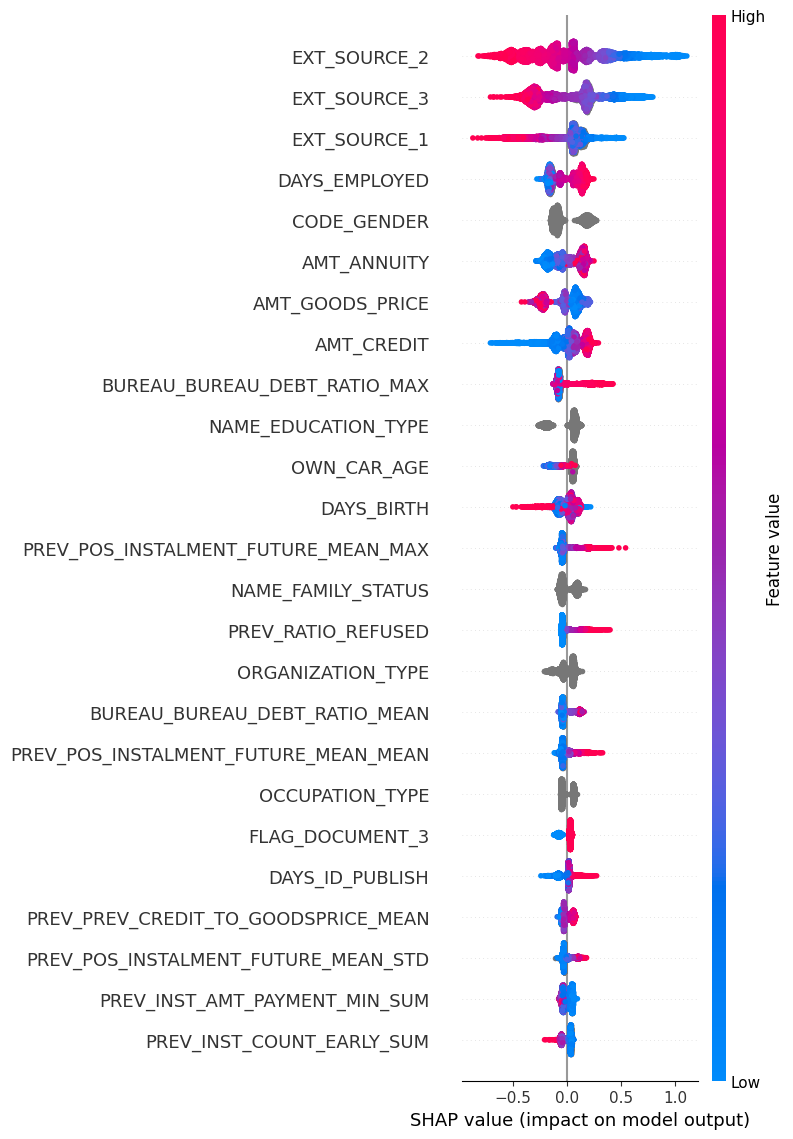

In [16]:
# --- Beeswarm
plt.figure()
shap.summary_plot(shap_pos, X_shap, max_display=25, show=False)
plt.tight_layout()
swarm_file = SHAP_DIR / "shap_summary_beeswarm.png"
plt.savefig(swarm_file, dpi=220, bbox_inches="tight")
plt.show()
plt.close()

In [17]:
# --- CSV importance mean(|SHAP|)
mean_abs = np.abs(shap_pos).mean(axis=0)
shap_importance = (
    pd.DataFrame({"feature": X_shap.columns, "mean_abs_shap": mean_abs})
      .sort_values("mean_abs_shap", ascending=False)
      .reset_index(drop=True)
)
csv_file = SHAP_DIR / "shap_global_importance.csv"
shap_importance.to_csv(csv_file, index=False)

top20_feats = shap_importance.head(20)["feature"].tolist()

print("SHAP global saved:", bar_file.name, swarm_file.name, csv_file.name)

SHAP global saved: shap_summary_bar.png shap_summary_beeswarm.png shap_global_importance.csv


### Analyse locale (waterfall plot – exemple individuel)

Dans cet exemple :

- Les variables **EXT_SOURCE_2** et **EXT_SOURCE_3** ont une contribution fortement négative.
  Des scores externes élevés réduisent significativement le risque de défaut et constituent les principaux facteurs favorables à l’acceptation du dossier.

- L’**ancienneté professionnelle (DAYS_EMPLOYED)** et l’**âge du véhicule (OWN_CAR_AGE)** contribuent également à diminuer le risque.

- L’historique de paiement passé (**PREV_INST_COUNT_OVERPAID\_STD, PREV_INST_AMT_PAYMENT\_SUM\_MEAN, PREV_INST_AMT_PAYMENT\_SUM\_MAX**) joue un rôle important dans la réduction du risque, traduisant un comportement de remboursement favorable.

- À l’inverse, le montant du crédit (**AMT_CREDIT**) a une contribution positive, augmentant légèrement le risque de défaut.

Au final, la somme des contributions conduit à un score final très négatif,
indiquant une **probabilité de défaut faible** et donc une décision favorable pour ce client.

Cette analyse montre que la décision est principalement guidée par :
- les scores externes,
- la stabilité professionnelle,
- le bon comportement de remboursement passé,
ce qui est cohérent avec les principes classiques du scoring bancaire.

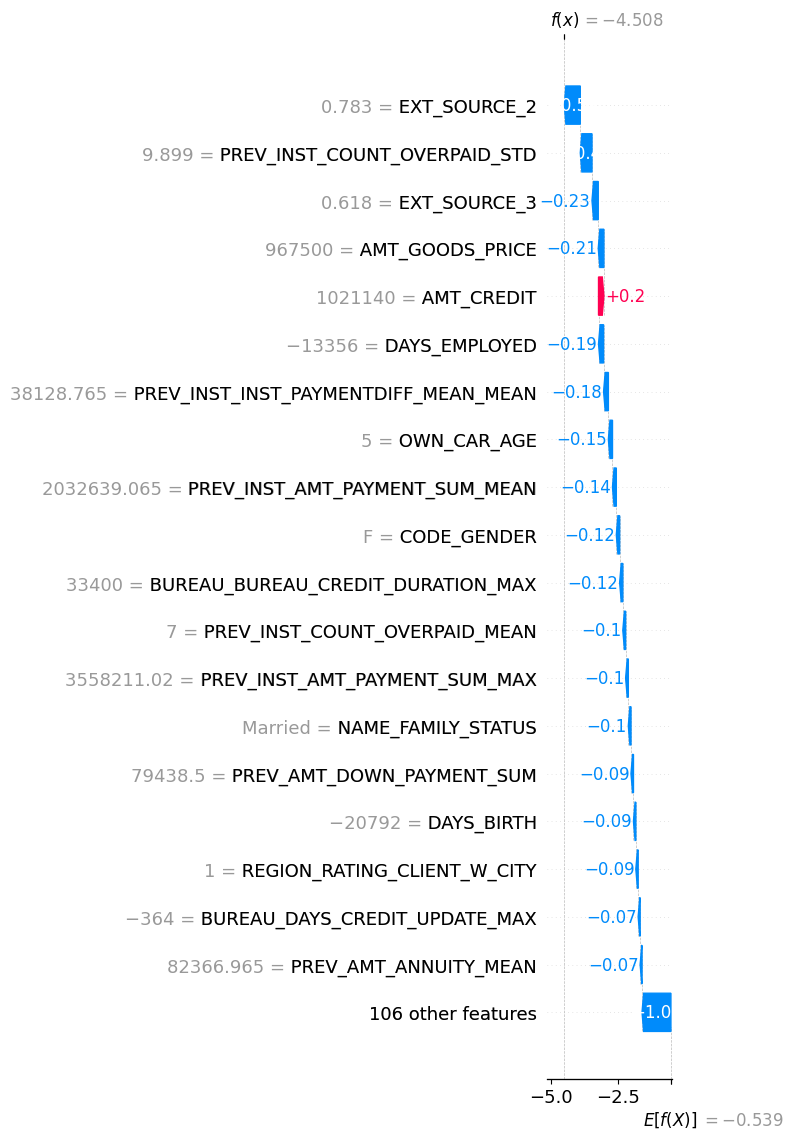

In [18]:


# indices accepté/refusé selon seuil thr_cb
proba_np = np.asarray(proba_test)
idx_refused = np.where(proba_np >= thr_cb)[0]
idx_accepted = np.where(proba_np < thr_cb)[0]

# accepté = le plus "safe" parmi ceux acceptés (proba min)
idx_acc = int(idx_accepted[np.argmin(proba_np[idx_accepted])]) if len(idx_accepted) else int(np.argmin(proba_np))
# refusé = le plus "risky" parmi ceux refusés (proba max)
idx_ref = int(idx_refused[np.argmax(proba_np[idx_refused])]) if len(idx_refused) else int(np.argmax(proba_np))

# base value (selon versions)
ev = explainer.expected_value
base_value = float(ev[1]) if isinstance(ev, (list, np.ndarray)) and len(ev) == 2 else float(ev)

# ----- Waterfall ACCEPTED
x_acc = X_test_cb.iloc[[idx_acc]]
sv_acc = explainer.shap_values(x_acc)
sv_acc_pos = sv_acc[1] if isinstance(sv_acc, list) and len(sv_acc) == 2 else sv_acc

exp_acc = shap.Explanation(
    values=sv_acc_pos[0],
    base_values=base_value,
    data=x_acc.iloc[0].values,
    feature_names=x_acc.columns.tolist(),
)

plt.figure()
shap.plots.waterfall(exp_acc, max_display=20, show=False)
plt.tight_layout()
wf_acc_file = SHAP_DIR / "shap_waterfall_accepted.png"
plt.savefig(wf_acc_file, dpi=220, bbox_inches="tight")
plt.show()
plt.close()

Dans cet exemple :

- Les variables **EXT_SOURCE_2** et **EXT_SOURCE_3** ont une contribution fortement négative.
  Des scores externes élevés réduisent significativement le risque de défaut et constituent les principaux facteurs favorables à l’acceptation du dossier.

- L’**ancienneté professionnelle (DAYS_EMPLOYED)** et l’**âge du véhicule (OWN_CAR_AGE)** contribuent également à diminuer le risque, traduisant une situation professionnelle et patrimoniale plus stable.

- L’historique de paiement passé  
(**PREV_INST_COUNT_OVERPAID_STD, PREV_INST_AMT_PAYMENT_SUM_MEAN, PREV_INST_AMT_PAYMENT_SUM_MAX**)  
joue un rôle important dans la réduction du risque, reflétant un comportement de remboursement favorable.

- À l’inverse, le montant du crédit (**AMT_CREDIT**) présente une contribution positive, augmentant légèrement le risque de défaut en raison d’un engagement financier plus élevé.

Au final, la somme des contributions conduit à un score final très négatif, indiquant une **probabilité de défaut faible** et donc une **décision favorable** pour ce client.

Cette analyse montre que la décision est principalement guidée par :
- les scores externes,
- la stabilité professionnelle,
- le bon comportement de remboursement passé,

ce qui est pleinement cohérent avec les principes classiques du scoring bancaire.

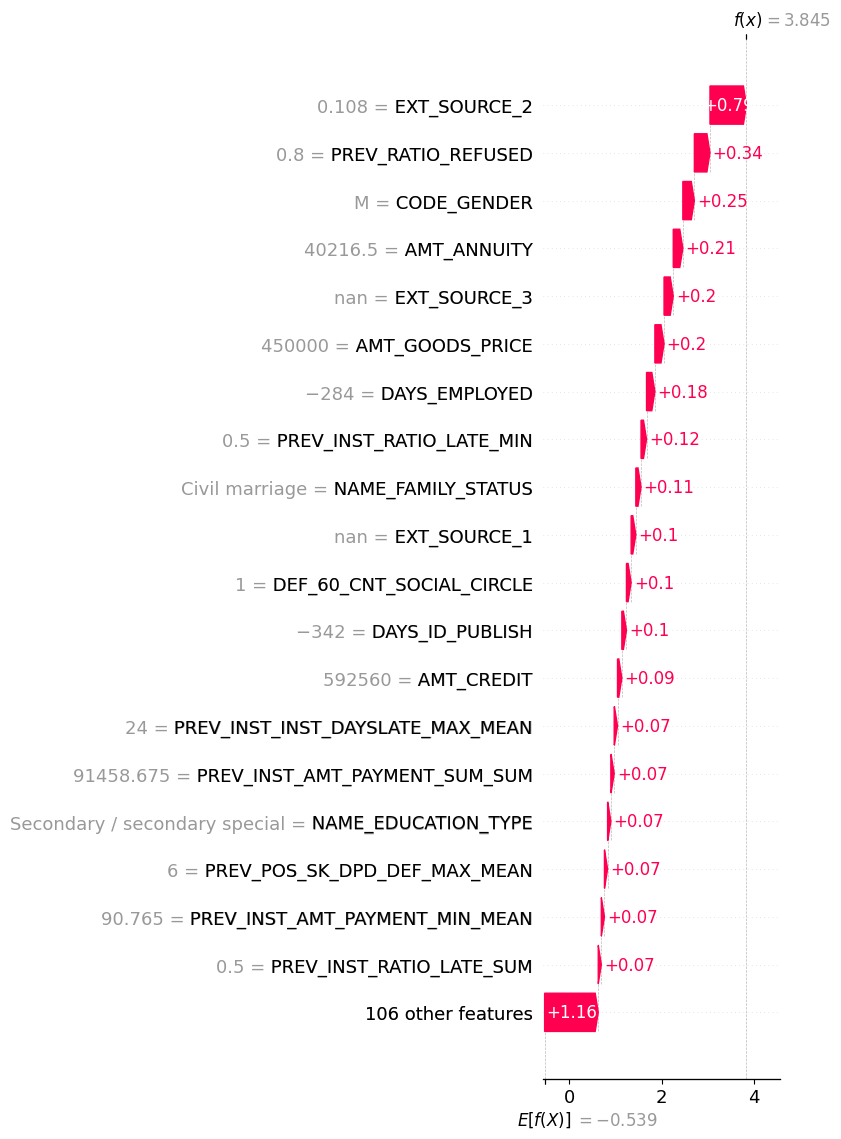

SHAP local saved: shap_waterfall_accepted.png shap_waterfall_refused.png
Local examples idx: {'accepted': 14980, 'refused': 42710}


In [19]:
# ----- Waterfall REFUSED
x_ref = X_test_cb.iloc[[idx_ref]]
sv_ref = explainer.shap_values(x_ref)
sv_ref_pos = sv_ref[1] if isinstance(sv_ref, list) and len(sv_ref) == 2 else sv_ref

exp_ref = shap.Explanation(
    values=sv_ref_pos[0],
    base_values=base_value,
    data=x_ref.iloc[0].values,
    feature_names=x_ref.columns.tolist(),
)

plt.figure()
shap.plots.waterfall(exp_ref, max_display=20, show=False)
plt.tight_layout()
wf_ref_file = SHAP_DIR / "shap_waterfall_refused.png"
plt.savefig(wf_ref_file, dpi=220, bbox_inches="tight")
plt.show()
plt.close()

print("SHAP local saved:", wf_acc_file.name, wf_ref_file.name)
print("Local examples idx:", {"accepted": idx_acc, "refused": idx_ref})

In [20]:
from pathlib import Path
import json
import tempfile
import mlflow

with mlflow.start_run(run_name="FINAL_WITH_SHAP_CatBoost"):

    # -----------------
    # Tags (contexte run)
    # -----------------
    mlflow.set_tag("phase", "final_with_shap")
    mlflow.set_tag("model_name", WINNER_NAME)
    mlflow.set_tag("feature_set", FEATURE_SET_NAME)
    mlflow.set_tag("dataset_train", "train+valid")
    mlflow.set_tag("dataset_test", "test_split")

    # -----------------
    # Threshold / coûts / beta
    # -----------------
    mlflow.log_param("threshold_business", float(thr_cb))
    mlflow.log_param("cost_fn", int(COST_FN))
    mlflow.log_param("cost_fp", int(COST_FP))
    mlflow.log_param("fbeta_beta", int(FBETA_BETA))

    mlflow.log_metric("threshold_business", float(thr_cb))

    # -----------------
    # Params modèle
    # -----------------
    for k, v in final_params_cb.items():
        mlflow.log_param(f"cb.{k}", v)

    # -----------------
    # Metrics test
    # -----------------
    for k, v in winner_test_metrics.items():
        if k != "threshold":
            mlflow.log_metric(f"test.{k}", float(v))

    # -----------------
    # Artefacts SHAP
    # -----------------
    mlflow.log_artifact(str(bar_file), artifact_path="shap")
    mlflow.log_artifact(str(swarm_file), artifact_path="shap")
    mlflow.log_artifact(str(csv_file), artifact_path="shap")
    mlflow.log_artifact(str(wf_acc_file), artifact_path="shap")
    mlflow.log_artifact(str(wf_ref_file), artifact_path="shap")

    mlflow.set_tag("shap.top20_features", ", ".join(top20_feats))
    mlflow.set_tag("shap.local_examples", f"accepted_idx={idx_acc}, refused_idx={idx_ref}")

    # -----------------
    # Artefacts API (kept + cat + threshold)
    # -----------------
    mlflow.log_artifact(str(kept_file), artifact_path="api_artifacts")

    with tempfile.TemporaryDirectory() as tmp:
        tmp = Path(tmp)


        cat_features_list = cat_idx_tv

        cat_file_tmp = tmp / f"cat_features_{FEATURE_SET_NAME}.txt"
        cat_file_tmp.write_text("\n".join(cat_features_list) + "\n", encoding="utf-8")
        mlflow.log_artifact(str(cat_file_tmp), artifact_path="api_artifacts")

        # 2) threshold -> fichier JSON
        threshold_file = tmp / f"threshold_{WINNER_NAME.lower()}_{FEATURE_SET_NAME}.json"
        threshold_file.write_text(json.dumps({"threshold": float(thr_cb)}, indent=2), encoding="utf-8")
        mlflow.log_artifact(str(threshold_file), artifact_path="api_artifacts")

        # Tags pour retrouver vite les fichiers côté API
        mlflow.set_tag("api.kept_features_file", kept_file.name)
        mlflow.set_tag("api.cat_features_file", cat_file_tmp.name)
        mlflow.set_tag("api.threshold_file", threshold_file.name)

    # -----------------
    # Register modèle
    # -----------------
    mlflow.catboost.log_model(
        cb_model=winner_model,
        artifact_path="model",
        registered_model_name=REGISTRY_NAME
    )

print(f"Run FINAL_WITH_SHAP loggé + modèle registré dans '{REGISTRY_NAME}'.")

2026/02/18 10:34:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run FINAL_WITH_SHAP loggé + modèle registré dans 'home_credit_catboost'.


Registered model 'home_credit_catboost' already exists. Creating a new version of this model...
Created version '2' of model 'home_credit_catboost'.


### Conclusion interprétabilité
L’analyse SHAP confirme que :
le modèle s’appuie principalement sur des variables métier pertinentes (scores externes, historique crédit, charge financière),
les relations apprises sont cohérentes avec les principes du scoring bancaire,
chaque décision individuelle peut être expliquée de manière transparente.
Cette étape garantit la compréhension, la traçabilité et la conformité réglementaire du modèle retenu pour le déploiement.